In [2]:
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress
import pandas as pd
import pickle
from os import listdir
from os.path import isfile, join
from ll_xy import lonlat_to_xy
from netCDF4 import Dataset
import mask
from field_importer import get_field
from scipy.spatial import KDTree
import itertools

In [29]:
sit_dict = pickle.load(open('../data/sits.p','rb'))

In [30]:
locations = {'a':(75,-152),
             'b':(78,-150),
             'd':(74,-140),
            }
loc_xy = {}
for loc in locations.keys():
    
    x,y = lonlat_to_xy(np.array(locations[loc][1]),
                       np.array(locations[loc][0]),
                       hemisphere='n')
    loc_xy[loc] = (x,y)

loc_xy

lons, lats = mask.get('lon'), mask.get('lat')
ex, ey = lonlat_to_xy(lons,lats,hemisphere='n')

tree = KDTree(list(zip(ex.ravel(),ey.ravel())))

inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (361,361))
    
    inds[buoy] = ind2d

In [31]:
yearlist = np.arange(2011,2021)
monthlist = ["10","11","12","01","02","03","04"]

In [32]:

colors = {'a':'g','b':'r','c':'orange','d':'purple'}

master_df = []

for buoy in ['a','b','d']:

    dfs = []
    for year in np.arange(2005,2021):
        
        try:
            with h5py.File(f'../data/ULS/ULS/uls{str(year-2000).zfill(2)}{buoy}_dailyn.mat') as mat:

                x = np.array(mat['IDS'])[1]
                dt = np.array(mat['yday'])[0]

                j1 = datetime.date(year,1,1)

                dates = [j1+datetime.timedelta(days=int(d)) for d in dt]
                months = [d.month for d in dates]
                years = [d.year for d in dates]

                df = pd.DataFrame({'draft':x,
                               'date':dates,
                               'year':years,
                               'month':months})

                dfs.append(df)
            
        except:
            pass
        
    df = pd.concat(dfs)
    
        
    years_active = set(df['year'])
    
    list_of_dicts = []    

    for year in np.arange(2011,2021):

        df_yr = df[df['year']==year]

        for month in monthlist:

            df_yr_mo = df_yr[df_yr['month']==int(month)]

            list_of_dicts.append({'year':year,'month':month,'draft':np.nanmean(df_yr_mo['draft'])})

    df_mo = pd.DataFrame(list_of_dicts).dropna()
    

    climatology = []
    SITS = []
    
    for month, year in zip(df_mo['month'],df_mo['year']):
        
        climatology.append( np.nanmean( df_mo[df_mo['month']==month]['draft'] ) * 1.1 )
        


    df_mo['Climatology'] = climatology

    
    df_mo['buoy'] = buoy
    
    master_df.append(df_mo)

master_df = pd.concat(master_df)

/tmp/ipykernel_151584/1140459476.py:47: RuntimeWarning: Mean of empty slice
  list_of_dicts.append({'year':year,'month':month,'draft':np.nanmean(df_yr_mo['draft'])})


# Now get the indices of the buoys in each SIT product

In [33]:
# AWI

d = Dataset('/home/robbie/Dropbox/SM_Thickness_Thesis/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201202-fv2p3.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

awi_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (432,432))
    
    awi_e2_inds[buoy] = ind2d

In [34]:
d = Dataset('../data/NSIDC/NSIDC/RDEFT4_20101114.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

nsidc_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (448,304))
    
    nsidc_e2_inds[buoy] = ind2d

In [35]:
d = Dataset('../data/W99/W99_361.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

w99_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (361,361))
    
    w99_e2_inds[buoy] = ind2d

In [36]:
df = pd.read_csv('../data/cpom/CPOM_CS2/201103.txt',sep = ' ')
cpom_lat = np.array(df.iloc[:,0])
cpom_lon = np.array(df.iloc[:,1])

cpom_longrid = np.reshape(cpom_lon, (1335, 1335))
cpom_latgrid = np.reshape(cpom_lat, (1335, 1335))

e2_x, e2_y = lonlat_to_xy(cpom_longrid,cpom_latgrid,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

cpom_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (1335,1335))
    
    cpom_e2_inds[buoy] = ind2d

In [37]:
buoy_inds = {'cpom':cpom_e2_inds,
            'awi':awi_e2_inds,
            'nsidc':nsidc_e2_inds,
            'w99':w99_e2_inds}

In [38]:
master_df

,year,month,draft,Climatology,buoy
7,2012,10,0.000193,0.261445,a
8,2012,11,0.296298,0.577780,a
9,2012,12,0.601119,0.875019,a
14,2013,10,1.024845,0.261445,a
15,2013,11,1.142000,0.577780,a
...,...,...,...,...,...
65,2020,12,0.733917,1.060489,d
66,2020,01,1.049609,1.254270,d
67,2020,02,1.278311,1.498224,d
68,2020,03,1.466130,1.724676,d


In [39]:
buoy_inds

{'cpom': {'a': (514, 956), 'b': (537, 893), 'd': (443, 934)},
 'awi': {'a': (157, 184), 'b': (169, 189), 'd': (161, 170)},
 'nsidc': {'a': (214, 91), 'b': (220, 103), 'd': (227, 84)},
 'w99': {'a': (239, 149), 'b': (226, 153), 'd': (234, 135)}}

In [43]:
buoy_sits = {s:[] for s in buoy_inds.keys()}

for month, year, buoy in zip(master_df['month'],master_df['year'],master_df['buoy']):
    
    for product in buoy_sits.keys():
        
        sit = sit_dict[product][year][month]
        buoy_ind = buoy_inds[product][buoy]
        
        buoy_sits[product].append(sit[buoy_ind])
        

for product in buoy_sits.keys():
    master_df[f'{product.upper()}_SIT'] = buoy_sits[product]
    
master_df

,year,month,draft,Climatology,buoy,cpom_SIT,awi_SIT,nsidc_SIT,w99_SIT,CPOM_SIT,AWI_SIT,NSIDC_SIT,W99_SIT
7,2012,10,0.000193,0.261445,a,0.0000,NaN,NaN,0.589068,0.0000,NaN,NaN,0.589068
8,2012,11,0.296298,0.577780,a,1.2222,0.991547,1.095163,0.751418,1.2222,0.991547,1.095163,0.751418
9,2012,12,0.601119,0.875019,a,1.3826,0.796166,1.439618,0.832887,1.3826,0.796166,1.439618,0.832887
14,2013,10,1.024845,0.261445,a,1.0889,1.064659,1.466293,0.589068,1.0889,1.064659,1.466293,0.589068
15,2013,11,1.142000,0.577780,a,1.6474,1.812615,1.697625,0.751418,1.6474,1.812615,1.697625,0.751418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020,12,0.733917,1.060489,d,1.3878,0.784678,1.305944,0.849238,1.3878,0.784678,1.305944,0.849238
66,2020,01,1.049609,1.254270,d,1.1374,1.332576,1.442706,1.062369,1.1374,1.332576,1.442706,1.062369
67,2020,02,1.278311,1.498224,d,1.0642,1.425656,1.090390,1.430937,1.0642,1.425656,1.090390,1.430937
68,2020,03,1.466130,1.724676,d,1.7035,1.818803,1.608235,1.594553,1.7035,1.818803,1.608235,1.594553


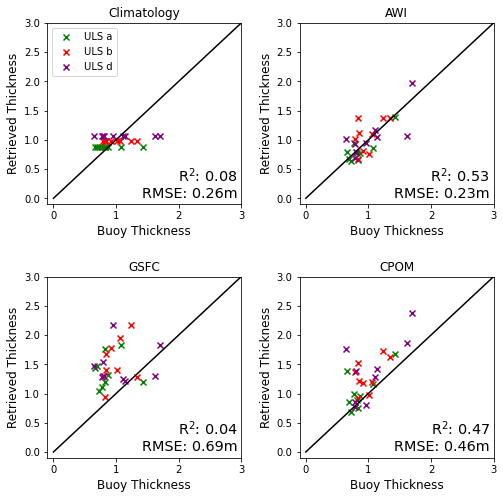

In [47]:
m = '12'

fig, axs = plt.subplots(2,2,figsize=(8,8))

for var,label,ax in zip(['Climatology','AWI_SIT','NSIDC_SIT','CPOM_SIT'],
                        ['Climatology','AWI','GSFC','CPOM'],
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        df = df[df['month']==m]
        
        ax.scatter(df['draft']*1.1,df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['draft',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    df = df[df['month']==m]
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['draft'])))
    
    lr = linregress(df['draft']*1.1,df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

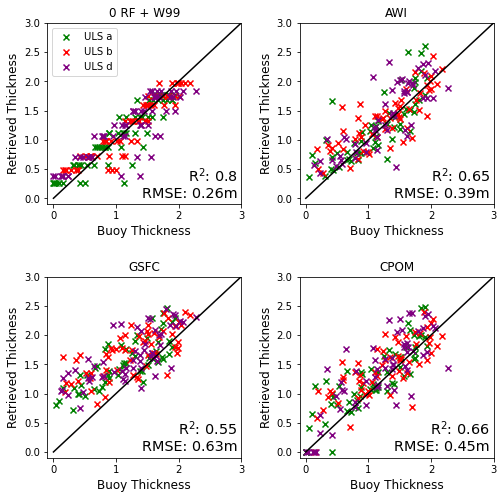

In [45]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

for var,label,ax in zip(['Climatology','awi_SIT','NSIDC_SIT','CPOM_SIT'],
                        ['0 RF + W99','AWI','GSFC','CPOM'],
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        ax.scatter(df['draft']*1.1,df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['draft',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['draft'])))
    
    lr = linregress(df['draft']*1.1,df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

In [48]:
products = ['AWI_SIT','NSIDC_SIT','CPOM_SIT']

pclims = []

for month, buoy in itertools.product(monthlist,['a','b','d']):
    
    cd = master_df[(master_df['month']==month) & (master_df['buoy']==buoy)]
    
    for product in products:
        
        nm = np.nanmean(cd[product])
        
        
        pclims.append( {'product':product,'month':month,'buoy':buoy,'SIT':nm} )
    
df = pd.DataFrame(pclims)
df

,product,month,buoy,SIT
0,AWI_SIT,10,a,0.707611
1,NSIDC_SIT,10,a,1.082838
2,CPOM_SIT,10,a,0.453278
3,AWI_SIT,10,b,0.898368
4,NSIDC_SIT,10,b,1.434513
...,...,...,...,...
58,NSIDC_SIT,04,b,2.026193
59,CPOM_SIT,04,b,1.843488
60,AWI_SIT,04,d,2.062532
61,NSIDC_SIT,04,d,1.958473


In [49]:
pclims = {p:[] for p in products}

for month, buoy in zip(master_df['month'],master_df['buoy']):

    for product in products:
    
        val  = float(df[(df['product']==product)&(df['buoy']==buoy)&(df['month']==month)]['SIT'])
        
        pclims[product].append(val)
        
for p in products:
    
    master_df[p+'_c'] = pclims[p]
    
master_df

,year,month,draft,Climatology,buoy,cpom_SIT,awi_SIT,nsidc_SIT,w99_SIT,CPOM_SIT,AWI_SIT,NSIDC_SIT,W99_SIT,AWI_SIT_c,NSIDC_SIT_c,CPOM_SIT_c
7,2012,10,0.000193,0.261445,a,0.0000,NaN,NaN,0.589068,0.0000,NaN,NaN,0.589068,0.707611,1.082838,0.453278
8,2012,11,0.296298,0.577780,a,1.2222,0.991547,1.095163,0.751418,1.2222,0.991547,1.095163,0.751418,0.865004,1.206997,1.003633
9,2012,12,0.601119,0.875019,a,1.3826,0.796166,1.439618,0.832887,1.3826,0.796166,1.439618,0.832887,0.832430,1.375116,1.037100
14,2013,10,1.024845,0.261445,a,1.0889,1.064659,1.466293,0.589068,1.0889,1.064659,1.466293,0.589068,0.707611,1.082838,0.453278
15,2013,11,1.142000,0.577780,a,1.6474,1.812615,1.697625,0.751418,1.6474,1.812615,1.697625,0.751418,0.865004,1.206997,1.003633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020,12,0.733917,1.060489,d,1.3878,0.784678,1.305944,0.849238,1.3878,0.784678,1.305944,0.849238,1.068883,1.481900,1.390567
66,2020,01,1.049609,1.254270,d,1.1374,1.332576,1.442706,1.062369,1.1374,1.332576,1.442706,1.062369,1.371101,1.622455,1.489488
67,2020,02,1.278311,1.498224,d,1.0642,1.425656,1.090390,1.430937,1.0642,1.425656,1.090390,1.430937,1.390579,1.754003,1.409025
68,2020,03,1.466130,1.724676,d,1.7035,1.818803,1.608235,1.594553,1.7035,1.818803,1.608235,1.594553,1.796822,1.996263,1.754938


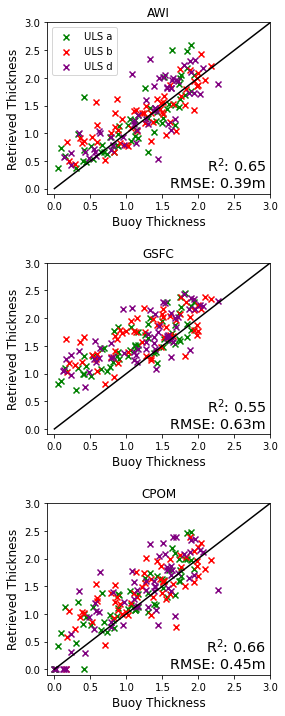

In [50]:
fig, axs = plt.subplots(3,1,figsize=(4,12))

for var,label,ax in zip(['awi_SIT','NSIDC_SIT','CPOM_SIT'],
                        ['AWI','GSFC','CPOM'],
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        ax.scatter(df['draft']*1.1,df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['draft',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['draft'])))
    
    lr = linregress(df['draft']*1.1,df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

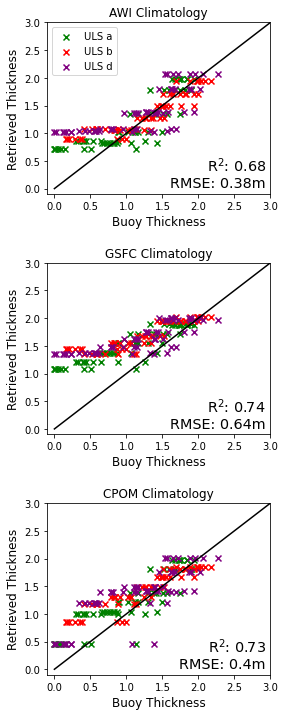

In [52]:
fig, axs = plt.subplots(3,1,figsize=(4,12))

for var,label,ax in zip(['AWI_SIT_c','NSIDC_SIT_c','CPOM_SIT_c'],
                        ['AWI Climatology','GSFC Climatology','CPOM Climatology'],
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        ax.scatter(df['draft']*1.1,df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['draft',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['draft'])))
    
    lr = linregress(df['draft']*1.1,df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()